# Setup and Preparations for Predictions

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# set random seed for all algos
rseed = 42

# suppress future warnings for xgboost in this notebook
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# plotting style for plots later on
plt.style.use("seaborn")

##### Prepare datasets for prediction

In [5]:
df_fp = pd.read_csv("data/fp_data_final.csv", index_col=0)
df_gk = pd.read_csv("data/gk_data_final.csv", index_col=0)
pd.set_option('display.max_columns', None)

# drop irrelevant rows

df_fp = df_fp.drop(["player_name","long_name","year_of_birth","height_cm","weight_kg","nationality","club"],axis=1)
df_gk = df_gk.drop(["player_name","long_name","year_of_birth","height_cm","weight_kg","nationality","club"],axis=1)

In [6]:
##### put final test set aside

# fieldplayers
train_set_fp = df_fp.sample(frac=0.80, random_state=rseed)
final_test_set_fp = df_fp.drop(train_set_fp.index)

# goal keepers
train_set_gk = df_gk.sample(frac=0.80, random_state=rseed)
final_test_set_gk = df_gk.drop(train_set_gk.index)

print("Fieldplayers: ")
print(train_set_fp.shape)
print(final_test_set_fp.shape)
print("-----------------------")
print("Goalkeepers: ")
print(train_set_gk.shape)
print(final_test_set_gk.shape)

Fieldplayers: 
(8598, 54)
(2149, 54)
-----------------------
Goalkeepers: 
(1110, 37)
(277, 37)


# Define Pipelines

## Preprocessing Pipeline

In [7]:
def preprocessing_pipeline (train_set, scaler, encoder):

    ######################################################################
    # I. train-test-split
    ######################################################################

    from sklearn.model_selection import train_test_split

    X = train_set.drop(["market_value_in_euro"],axis=1)

    y = train_set["market_value_in_euro"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rseed)

    ###################################
    # II. Build preprocessing pipeline with
    # - a scaler for numerical columns
    # - an encoder for categorical columns
    # --> scaler and encoder need to be imported before function is called
    ###################################

    from sklearn.pipeline import Pipeline  

    numeric_transformer = Pipeline(steps=[
        ('scaler', scaler)])

    categorical_transformer = Pipeline(steps=[
        ('encoder', encoder)])

    ######################################################################
    # III. Apply column transformer
    ######################################################################

    from sklearn.compose import ColumnTransformer

    numerical_features = train_set.select_dtypes(include=['int64', 'float64']).drop(["market_value_in_euro"],axis=1).columns
    categorical_features = train_set.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numerical_features),
            ("cat", categorical_transformer, categorical_features)])
    
    X_pre = preprocessor.fit_transform(X)
    
    ######################################################################
    # IV. Extract column names for feature importances later on
    ######################################################################
    
    
    numerical_features_names = list(numerical_features)
    encoded_categorical_features = preprocessor.named_transformers_["cat"]["encoder"]
    encoded_categorical_features_names = list(encoded_categorical_features.get_feature_names(categorical_features))
    column_names = numerical_features_names + encoded_categorical_features_names

    return X, y, X_train, X_test, y_train, y_test, column_names, preprocessor  

## Model Selection Pipeline

Regressors to be tested:
1. Linear Regression
6. Stochastic Gradient Descent
7. Decision Trees
8. Random Forest
9. AdaBoost
10. Gradient Tree Boosting
11. XGBoost


In [70]:
def model_selection_pipeline (preprocessor_pipeline, scoring="r2"):
    
    # get processed data from preprocessing pipeline
    X, y, X_train, X_test, y_train, y_test, column_names, preprocessor = preprocessor_pipeline

    ######################################################################
    # I. Define and import relevant algorithms
    ######################################################################

    from sklearn import linear_model
    from sklearn import svm
    from sklearn import tree
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import AdaBoostRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    import xgboost as xgb
    

    models = []
    models.append(("Linear Regression",linear_model.LinearRegression()))
    models.append(("SGD",linear_model.SGDRegressor(random_state=rseed)))
    models.append(("Decision Tree",tree.DecisionTreeRegressor(random_state=rseed)))
    models.append(("Random Forest",RandomForestRegressor(random_state=rseed,n_jobs=-1)))
    models.append(("AdaBoost",AdaBoostRegressor(random_state=rseed)))
    models.append(("GradientBoosting",GradientBoostingRegressor(random_state=rseed)))
    models.append(("XGBoost",xgb.XGBRegressor(random_state=rseed)))
    

    results = []
    names = []
    scoring = scoring
    
    ######################################################################
    # II. Fit models and calculate metric for each model
    ######################################################################
    
    from sklearn.pipeline import Pipeline
    
    from sklearn import model_selection
    from sklearn.model_selection import cross_val_score
    import math
    
    for name,regressor in models:
        
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', regressor)])
        
        pipe.fit(X_train, y_train)
        
        kfold = model_selection.KFold(n_splits=5, random_state=rseed, shuffle=True)
        cv_results = abs(model_selection.cross_val_score(pipe, X, y, cv=kfold, scoring=scoring))
        cv_mean = math.ceil(cv_results.mean())
        cv_std = math.ceil(cv_results.std())
        results.append(cv_results)
        names.append(name)
        
        from yellowbrick.regressor import residuals_plot
        from yellowbrick.datasets import load_concrete
        
        print(f"Residual plot for {name}")
        viz = residuals_plot(pipe, X_train, y_train, X_test, y_test, hist=False)

    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

Residual plot for Linear Regression


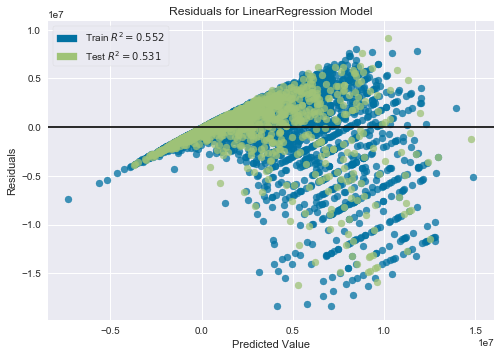

Residual plot for SGD


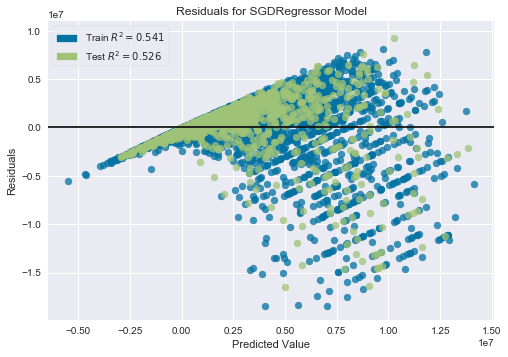

Residual plot for Decision Tree


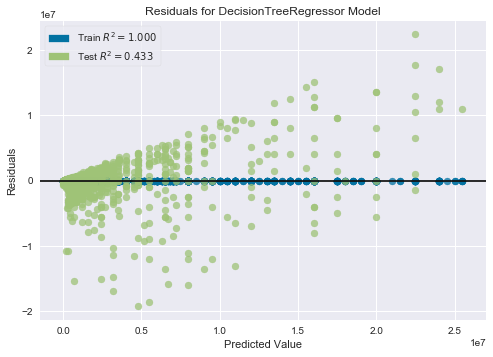

Residual plot for Random Forest


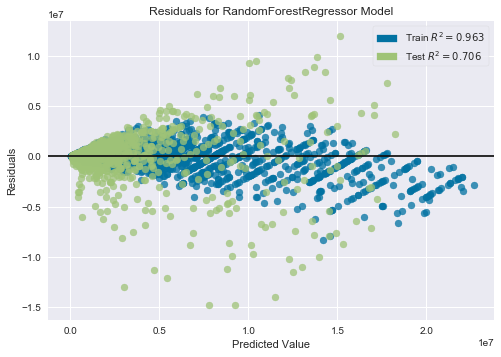

Residual plot for AdaBoost


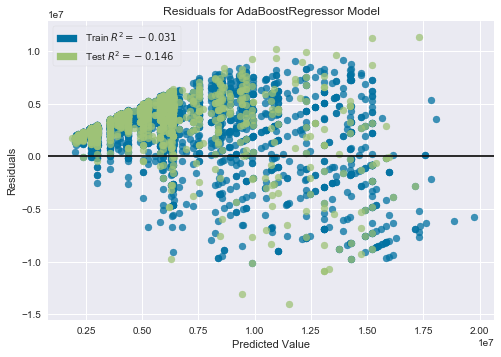

Residual plot for GradientBoosting


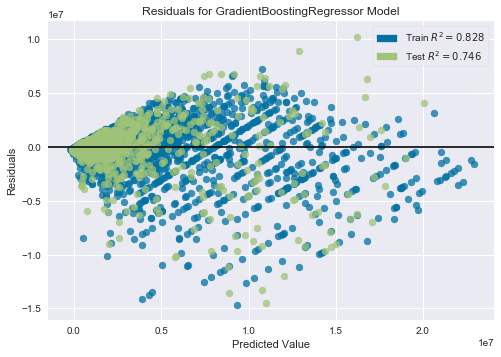

[19:49:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Residual plot for XGBoost


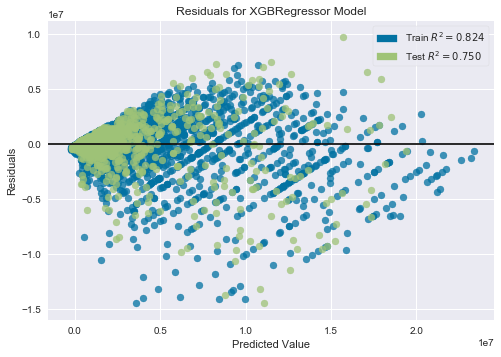

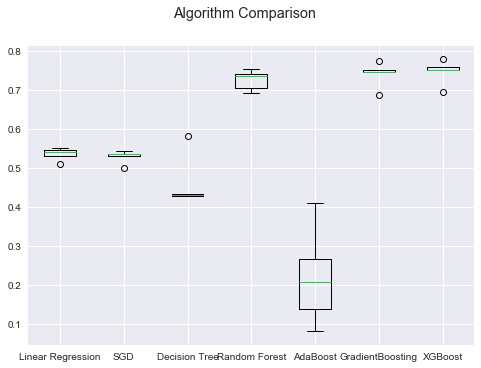

In [71]:
model_selection_pipeline (preprocessing_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder()))

##### --> Best 3 performing algorithms (in terms of R-squared) are Random Forest, GradientBoost and XGBoost!

##### --> these 3 are also our baseline models!

## RandomSearchCV Pipeline

narrow down, where to look for with gridsearch afterward

In [8]:
def randomsearch_pipeline(preprocessor_pipeline, model_name, model, param_distributions, scoring="r2"):
    
    # model needs to be a tuple of "(name, regressor)"
    
    # get processed data from preprocessing pipeline
    X, y, X_train, X_test, y_train, y_test, column_names, preprocessor = preprocessor_pipeline

    ###################################
    # I. 
    ###################################
    
    from sklearn.model_selection import RandomizedSearchCV
    
    param_distributions = param_distributions
    

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)])


    grid = RandomizedSearchCV(pipe, param_distributions = param_distributions, n_iter = 100, cv=3, scoring=scoring, random_state=rseed, n_jobs=-1)

    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)

    print("----------------------------------------------------------------------------------------------------------")
    print("\033[1m",model_name,"\033[0m")
    print("----------------------------------------------------------------------------------------------------------")
    print("Best hyperparameters:")
    print(grid.best_params_)
    print("-----------------------")
    print("Best score:")
    print(grid.best_score_)
    print("-----------------------")
    

In [ ]:
from sklearn.ensemble import RandomForestRegressor

param_distributions ={
'model__bootstrap': [True, False],
'model__max_depth': [1,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
'model__max_features': ['auto', 'sqrt'],
'model__min_samples_leaf': [1, 2, 4, 6],
'model__min_samples_split': [1, 2, 5, 10],
'model__n_estimators': [1, 20, 50, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

randomsearch_pipeline (preprocessing_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder()),
                       "Random Forest",RandomForestRegressor(random_state=rseed,n_jobs=-1),param_distributions)

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

param_distributions ={
    'model__learning_rate': [0.15,0.1,0.03, 0.05,0.07, 0.01,0.005,0.001],
    'model__n_estimators':[100,250,500,750,1000,1250,1500,1750],
    'model__max_depth':[1,2,3,4,5,6,7],
    'model__min_samples_split':[1,2,4,6,8,10,20,40,60,80, 100],
    'model__min_samples_leaf':[1,3,5,7,9,11,13,15],
    'model__max_features':[1,2,3,4,5,6,7],
    'model__subsample':[0.5, 0.55, 0.6, 0.65, 0.7,0.75,0.8,0.85,0.9,0.95,1]
}

randomsearch_pipeline (preprocessing_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder()),
                       "GradientBoosting",GradientBoostingRegressor(random_state=rseed),param_distributions)

----------------------------------------------------------------------------------------------------------
 GradientBoosting 
----------------------------------------------------------------------------------------------------------
Best hyperparameters:
{'model__subsample': 0.75, 'model__n_estimators': 1750, 'model__min_samples_split': 20, 'model__min_samples_leaf': 11, 'model__max_features': 7, 'model__max_depth': 7, 'model__learning_rate': 0.03}
-----------------------
Best score:
0.7106342314157014
-----------------------


In [14]:
import xgboost as xgb

param_distributions ={
    "model__learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.10, 0.15, 0.20, 0.25, 0.30] ,
    "model__max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    "model__min_child_weight": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    "model__gamma": [0.0, 0.1, 0.2 , 0.3, 0.4],
    "model__colsample_bytree":[ 0.3, 0.4, 0.5 , 0.7, 0.8, 0.9],
    "model__subsample":[0.5, 0.55, 0.6, 0.65, 0.7,0.75,0.8,0.85,0.9,0.95,1],
    "model__reg_alpha":[1e-5, 1e-2, 0.1, 0.5, 1, 10, 50, 100]
}

randomsearch_pipeline (preprocessing_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder()),
                       "XGBoost",xgb.XGBRegressor(random_state=rseed),param_distributions)

[13:10:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----------------------------------------------------------------------------------------------------------
 XGBoost 
----------------------------------------------------------------------------------------------------------
Best hyperparameters:
{'model__subsample': 0.9, 'model__reg_alpha': 10, 'model__min_child_weight': 11, 'model__max_depth': 5, 'model__learning_rate': 0.05, 'model__gamma': 0.0, 'model__colsample_bytree': 0.8}
-----------------------
Best score:
0.7423875772159785
-----------------------


## GridSearchCV Pipeline

In [ ]:
def gridsearch_pipeline(preprocessor_pipeline, model_name, model, param_grid, scoring="r2"):
    
    # model needs to be a tuple of "(name, regressor)"
    
    # get processed data from preprocessing pipeline
    X, y, X_train, X_test, y_train, y_test, column_names, preprocessor = preprocessor_pipeline

    ###################################
    # I. 
    ###################################
    
    from sklearn.model_selection import GridSearchCV
    
    param_grid = param_grid
    

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)])


    grid = RandomizedSearchCV(pipe, param_grid = param_grid, cv=5, scoring=scoring, random_state=rseed, n_jobs=-1)

    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)

    print("----------------------------------------------------------------------------------------------------------")
    print("\033[1m",model_name,"\033[0m")
    print("----------------------------------------------------------------------------------------------------------")
    print("Best hyperparameters:")
    print(grid.best_params_)
    print("-----------------------")

    # features importances

    feature_importances = grid.best_estimator_.named_steps["regressor"].feature_importances_
    feat_imp_df = pd.DataFrame({'feature':column_names,'importance':feature_importances})
    feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
    print("Feature importances:")
    print("------------------------------------------------------------")
    print(feat_imp_df.head(20))
    print("------------------------------------------------------------")
    print("------------------------------------------------------------")
    # Visualization of residuals

    from yellowbrick.regressor import residuals_plot
    from yellowbrick.datasets import load_concrete

    print(f"Residual plot for {model_name}")
    viz = residuals_plot(grid, X_train, y_train, X_test, y_test, hist=False)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

param_grid ={
'model__bootstrap': [XXX],
'model__max_depth': [XXX, XXX, XXX],
'model__max_features': [XXX],
'model__min_samples_leaf': [XXX, XXX, XXX],
'model__min_samples_split': [XXX, XXX, XXX],
'model__n_estimators': [XXX, XXX, XXX]
}

gridsearch_pipeline (preprocessing_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder()),
                       "Random Forest",RandomForestRegressor(random_state=rseed,n_jobs=-1),param_grid)

## Stacking Pipeline (with optimal hyperparameters from GridSearch)

##### stacking model function will be defined here for later

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html

In [ ]:
# stacking model for later

### need to give in list with tuples of (name, regressor)
### can be given from algo function above

    from sklearn.ensemble import StackingRegressor
    
    stacked_model = StackingRegressor(
        estimators = fitted_models,
        final_estimator=RandomForestRegressor(n_estimators=10,random_state=rseed)
    )
    
    stacked_model.fit(X_train, y_train).score(X_test, y_test)

# Residual Analysis

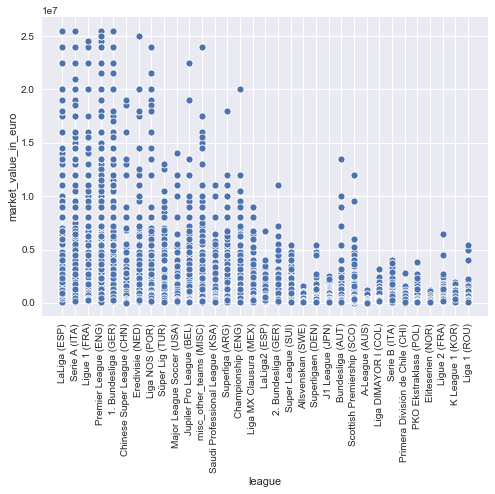

In [73]:
ax = sns.scatterplot(x="league", y="market_value_in_euro", data=df_fp)
plt.xticks(rotation='vertical');

[20:10:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Feature importances:
------------------------------------------------------------
                                feature  importance
3                               overall    0.250103
85          league_Premier League (ENG)    0.077118
0                            player_age    0.064485
21                movement_sprint_speed    0.034093
89                 league_Serie A (ITA)    0.031111
41  idfield_defense_positions_avg_score    0.028838
19                   skill_ball_control    0.027128
1                              division    0.026600
63           league_1. Bundesliga (GER)    0.025290
20                movement_acceleration    0.023118
23                   movement_reactions    0.020886
26                        power_jumping    0.017720
9                                physic    0.016412
81                 league_Ligue 1 (FRA)    0.014477
75                  le

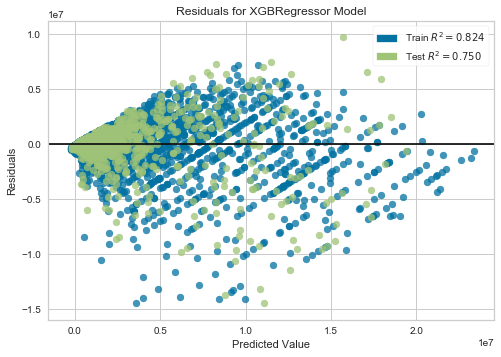

In [4]:
# Pipeline and predictions for XGB
###################################
# 2.1. train-test-split with remaining 80% of data
###################################

from sklearn.model_selection import train_test_split

X = train_set_fp.drop(["market_value_in_euro"],axis=1)

y = train_set_fp["market_value_in_euro"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rseed)

###################################
# 2.2. Build preprocessing pipeline with
# - a scaler for numerical columns
# - an encoder for categorical columns
###################################

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder


numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder())])

###################################
# 2.3. Apply column transformer
###################################
from sklearn.compose import ColumnTransformer

numerical_features = train_set_fp.select_dtypes(include=['int64', 'float64']).drop(["market_value_in_euro"],axis=1).columns
categorical_features = train_set_fp.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)])

X_preprocessed = preprocessor.fit_transform(X)

# get column names for feature importances later
numerical_features_names = list(numerical_features)
encoded_categorical_features = preprocessor.named_transformers_["cat"]["encoder"]
encoded_categorical_features_names = list(encoded_categorical_features.get_feature_names(categorical_features))
column_names = numerical_features_names + encoded_categorical_features_names

###################################
# 2.4. Fit algorithm
###################################

import xgboost as xgb


model = Pipeline(steps=[('preprocessor', preprocessor),
                  ('regressor', xgb.XGBRegressor(random_state=rseed))])

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


# features importances

feature_importances = model.named_steps["regressor"].feature_importances_
feat_imp_df = pd.DataFrame({'feature':column_names,'importance':feature_importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
print("Feature importances:")
print("------------------------------------------------------------")
print(feat_imp_df.head(20))
print("------------------------------------------------------------")
print("------------------------------------------------------------")
# Visualization of residuals

from yellowbrick.regressor import residuals_plot
from yellowbrick.datasets import load_concrete

viz = residuals_plot(model, X_train, y_train, X_test, y_test, hist=False)

In [16]:
# put together datasets again
df_fp_train = X_train.copy()
df_fp_train["y_actual"] = y_train
df_fp_train["y_predicted"] = y_pred_train

df_fp_test = X_test.copy()
df_fp_test["y_actual"] = y_test
df_fp_test["y_predicted"] = y_pred_test

# calculate residuals
df_fp_train["residuals"] = df_fp_train["y_actual"] - df_fp_train["y_predicted"]
df_fp_test["residuals"] = df_fp_test["y_actual"] - df_fp_test["y_predicted"]


# calculate R2 score
ssr_train = np.sum((df_fp_train["y_predicted"] - df_fp_train["y_actual"])**2)
ssr_test = np.sum((df_fp_test["y_predicted"] - df_fp_test["y_actual"])**2)

sst_train = np.sum((df_fp_train["y_actual"] - np.mean(df_fp_train["y_actual"]))**2)
sst_test = np.sum((df_fp_test["y_actual"] - np.mean(df_fp_test["y_actual"]))**2)

r2_score_train = 1 - (ssr_train/sst_train)
r2_score_test = 1 - (ssr_test/sst_test)

print(round(r2_score_train,3))
print(round(r2_score_test,3))

df_fp_train_for_save = df_fp_train[["y_actual","y_predicted","residuals"]]
df_fp_test_for_save = df_fp_test[["y_actual","y_predicted","residuals"]]


df_fp_train_for_save.to_csv('data/train_data_residuals.csv')
df_fp_test_for_save.to_csv('data/test_data_residuals.csv')

0.824
0.75


## ToDos for residual analysis


- alle categoricals checken --> DONE
- diagonal structure in residuals? --> googlen
- Prozentualer fehler-abweichung genauso wie die residuals normalisieren und als distplot

- y imbalanced --> transformieren --> DONE

- irgendwas falsch in pipeline?

In [6]:
cat_features = train_set_fp.select_dtypes(include=['object']).columns
cat_features

Index(['geographical_continent', 'main_position', 'positional_flexibility',
       'league', 'preferred_foot', 'weak_foot', 'attacking_work_rate',
       'defensive_work_rate', 'skill_moves'],
      dtype='object')

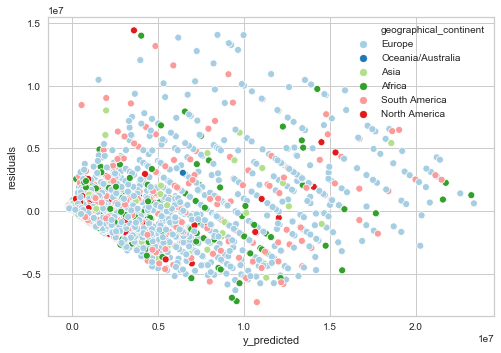

In [7]:
sns.scatterplot(x="y_predicted", y="residuals", hue="geographical_continent",data=df_fp_train, 
                legend="brief", palette="Paired");

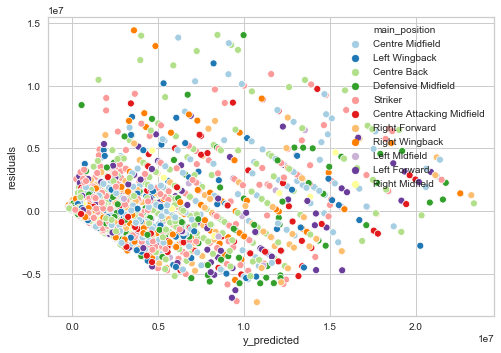

In [8]:
sns.scatterplot(x="y_predicted", y="residuals", hue="main_position",data=df_fp_train, 
                legend="brief", palette="Paired");

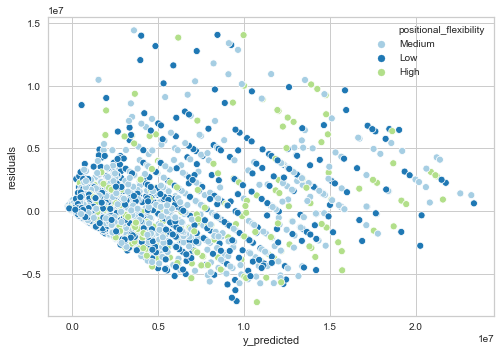

In [9]:
sns.scatterplot(x="y_predicted", y="residuals", hue="positional_flexibility",data=df_fp_train, 
                legend="brief", palette="Paired");

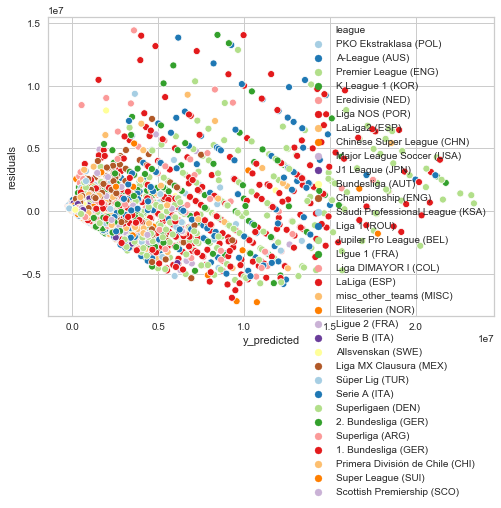

In [10]:
sns.scatterplot(x="y_predicted", y="residuals", hue="league",data=df_fp_train, 
                legend="brief", palette="Paired");

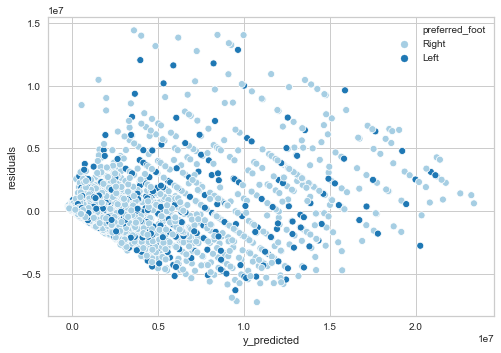

In [11]:
sns.scatterplot(x="y_predicted", y="residuals", hue="preferred_foot",data=df_fp_train, 
                legend="brief", palette="Paired");

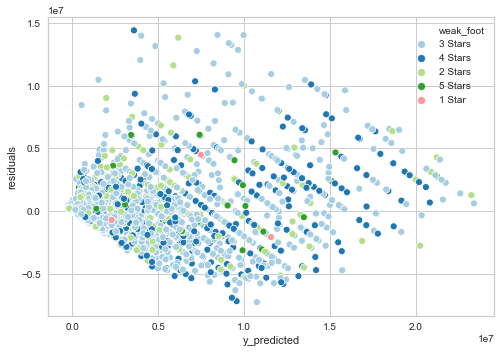

In [12]:
sns.scatterplot(x="y_predicted", y="residuals", hue="weak_foot",data=df_fp_train, 
                legend="brief", palette="Paired");

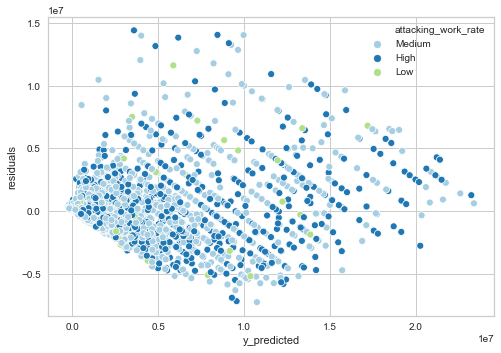

In [13]:
sns.scatterplot(x="y_predicted", y="residuals", hue="attacking_work_rate",data=df_fp_train, 
                legend="brief", palette="Paired");

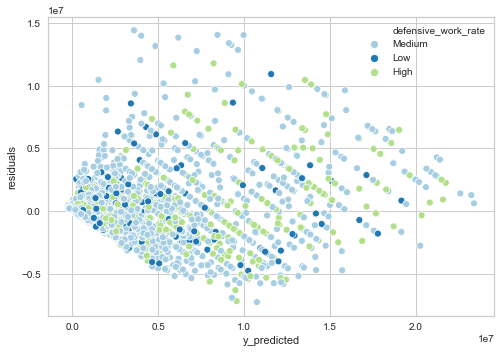

In [14]:
sns.scatterplot(x="y_predicted", y="residuals", hue="defensive_work_rate",data=df_fp_train, 
                legend="brief", palette="Paired");

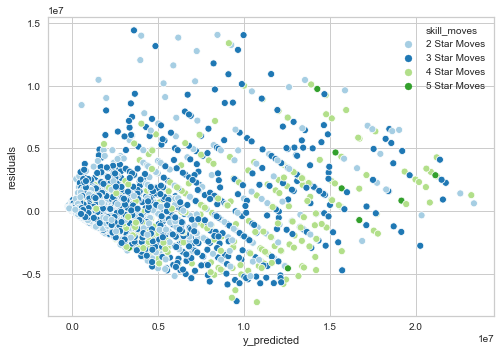

In [15]:
sns.scatterplot(x="y_predicted", y="residuals", hue="skill_moves",data=df_fp_train, 
                legend="brief", palette="Paired");

In [ ]:
# normalize residuals
plt.style.use("seaborn")
norm_resids = [float(i)/sum(df_fp_train["residuals"]) for i in df_fp_train["residuals"]]
sns.distplot(norm_resids, kde=False)

# todos after 2'

- Feature selection / Recursive elimination mit feature importances
- Model selection(k-best) anschauen (von dirk?)

- richtige GridSearch vor der Pipeline
- Stacking Pipeline mit den Gridparametern
- Dashboard